In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.seir import SEIR
from sir_models.seir import stepwise, get_quarantine_multiplier_value

# Load data

In [6]:
df = pd.read_csv('data/data.csv', sep=';')

In [7]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [8]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [9]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


In [14]:
df[df['total_dead'] > 0].iloc[0]

index                               1129
date                 2020-03-25 00:00:00
region                            Москва
total_infected                       410
total_recovered                       14
total_dead                             2
deaths_per_day                         2
infected_per_day                     120
recovered_per_day                      5
infected                             394
Name: 13, dtype: object

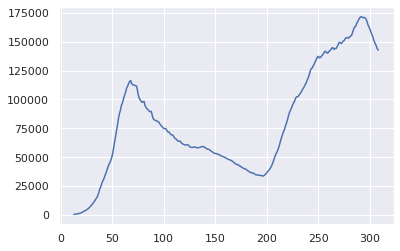

In [12]:
df['infected'].plot()

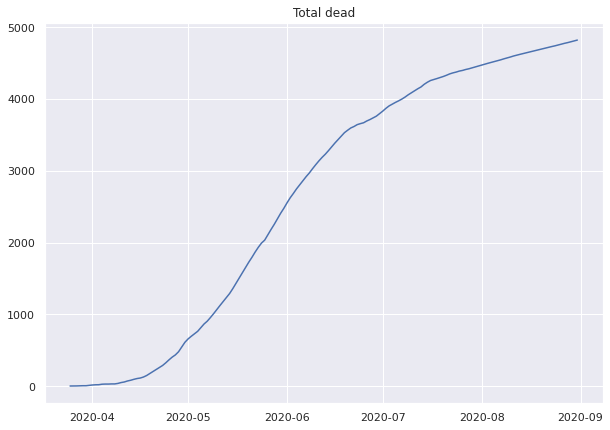

In [13]:
subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-08-31')]
plt.figure(figsize=(10, 7))
plt.plot(subset.date, subset.total_dead)
plt.title("Total dead")
plt.show()

# SEIR full

In [57]:
model = SEIR()
subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-08-31')]
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
result

In [58]:
subset.iloc[0]

index                               1129
date                 2020-03-25 00:00:00
region                            Москва
total_infected                       410
total_recovered                       14
total_dead                             2
deaths_per_day                         2
infected_per_day                     120
recovered_per_day                      5
infected                             394
Name: 13, dtype: object

In [59]:
S[0], I[0], R[0], D[0]

(9831094.57419568, 349.70334028980403, 471.51870180467364, 2.1607272485957547)

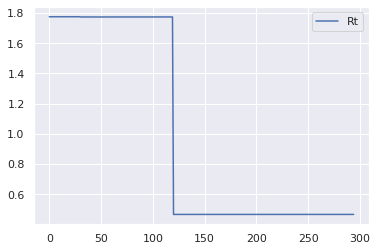

In [60]:
r0 = model.params['r0']
gamma = model.params['gamma']

rt_vals = []
for t in range(1, len(df)):
    rt_vals.append(r0 - get_quarantine_multiplier_value(t, model.params) * r0)
    
plt.figure()
plt.plot(rt_vals, label='Rt')
plt.legend()
plt.show()

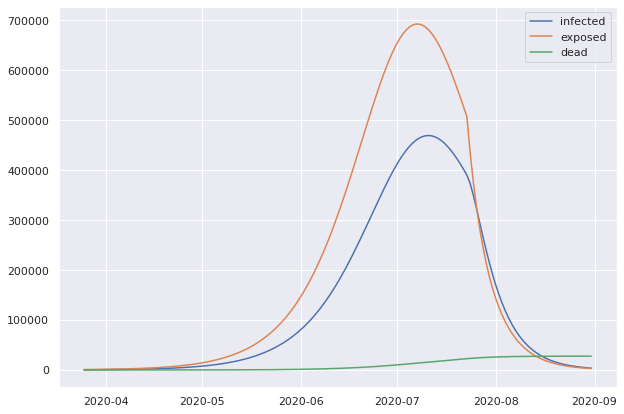

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(subset.date, I, label='infected')
plt.plot(subset.date, E, label='exposed')
#plt.plot(subset.date, R, label='recovered')
plt.plot(subset.date, D, label='dead')
plt.legend()
plt.show()

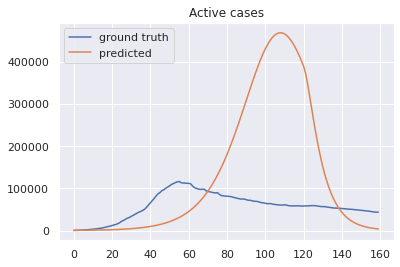

In [62]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

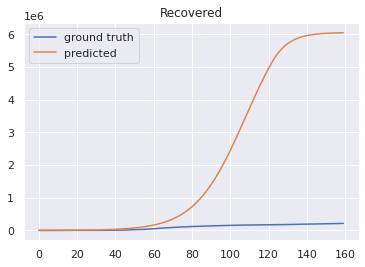

In [63]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

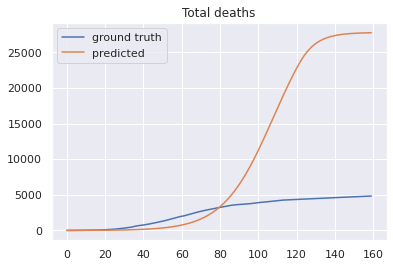

In [64]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

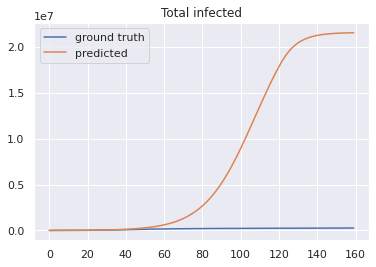

In [65]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()